In [2]:
import numpy as np
from io import BytesIO

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

## Preparing a toy dataset

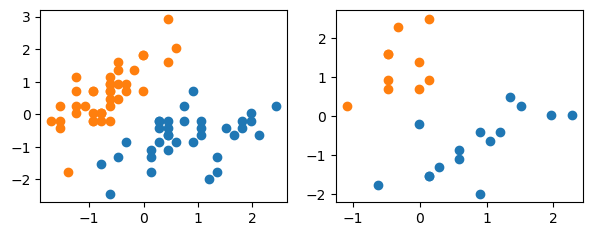

In [6]:
## Dataset

ds = np.lib.DataSource()
fp = ds.open('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')

x = np.genfromtxt(BytesIO(fp.read().encode()), delimiter=',', usecols=range(2), max_rows=100)
y = np.zeros(100)
y[50:] = 1

np.random.seed(1)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1])
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1])
plt.show()

## Low-level implementation with manual gradient

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def custom_where(cond, x_1, x_2):
    return (cond * x_1) + (~(cond) * x_2)

class LogisticRegression1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)
    
    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        probas = self._sigmoid(linear)
        return probas

    def backward(self, probas, y):
        errors = y - probas.view(-1)
        return errors

    def predict_labels(self, x):
        probas = self.forward(x)
        labels = custom_where(probas >= 0.5, 1, 0)
        return labels

    def evaluate(self, x, y):
        labels = self.predict_labels(x).float()
        accuracy = torch.sum(labels.view(-1) == y) / y.size()[0]
        return accuracy

    def _sigmoid(self, z):
        return 1. / (1. + torch.exp(-z))
    
    def _logit_cost(self, y, proba):
        tmp1 = torch.mm(-y.view(1, -1), torch.log(proba))
        tmp2 = torch.mm((1 - y).view(1, -1), torch.log(1 - proba))
        return tmp1 - tmp2

    def train(self, x, y, num_epochs, learning_rate=0.01):
        for e in range(num_epochs):

            ## compute output
            probas = self.forward(x)

            ## compute gradients
            errors = self.backward(probas, y)
            neg_grad = torch.mm(x.transpose(0, 1), errors.view(-1,1))

            ## update weights
            self.weights += learning_rate * neg_grad
            self.bias += learning_rate * torch.sum(errors)

            ## logging
            print('Epoch: %03 % (e+1)', end="")
            print(' | Train Acc: %.3f' % self.evaluate(x, y), end="")
            print(' | Cost: %3f' % self._logit_cost(y, self.forward(x)))
    

In [19]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

logr = LogisticRegression1(num_features=2)
logr.train(X_train_tensor, y_train_tensor, num_epochs=10, learning_rate=0.1)

print('\nModel parameters:')
print(' Weights: %s' % logr.weights)
print(' Bias: %s' % logr.bias)

Epoch: %03 % (e+1) | Train Acc: 0.987 | Cost: 5.581018
Epoch: %03 % (e+1) | Train Acc: 0.987 | Cost: 4.882451
Epoch: %03 % (e+1) | Train Acc: 1.000 | Cost: 4.381064
Epoch: %03 % (e+1) | Train Acc: 1.000 | Cost: 3.998165
Epoch: %03 % (e+1) | Train Acc: 1.000 | Cost: 3.693163
Epoch: %03 % (e+1) | Train Acc: 1.000 | Cost: 3.442688
Epoch: %03 % (e+1) | Train Acc: 1.000 | Cost: 3.232194
Epoch: %03 % (e+1) | Train Acc: 1.000 | Cost: 3.052091
Epoch: %03 % (e+1) | Train Acc: 1.000 | Cost: 2.895748
Epoch: %03 % (e+1) | Train Acc: 1.000 | Cost: 2.758410

Model parameters:
 Weights: tensor([[ 4.2267],
        [-2.9613]])
 Bias: tensor([0.0994])


## Evaluating the model

In [20]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = logr.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 100.00%


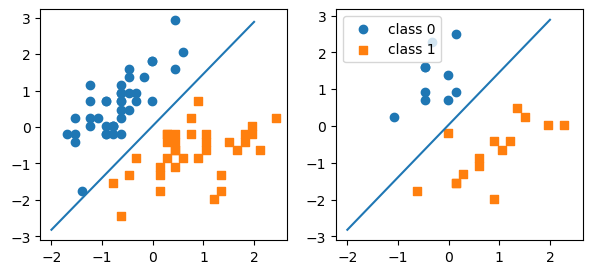

In [21]:
### 2D Decision Boundary

w, b = logr.weights, logr.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

## Low-level implementation using autograd

In [39]:
def custom_where(cond, x_1, x_2):
    return (cond * x_1) + (~(cond) * x_2)

class LogisticRegression2():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1,
                                   dtype=torch.float32,
                                   device=device,
                                   requires_grad=True) # req. for autograd
        self.bias = torch.zeros(1, dtype=torch.float32,
                          device = device,
                          requires_grad=True) # req. for autograd

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        probas = self._sigmoid(linear)
        return probas

    # def bacward() - implemented by autograd in torch

    def predict_labels(self, x):
        probas = self.forward(x)
        labels = custom_where(probas > 0.5, 1, 0)
        return labels

    def evaluate(self, x, y):
        labels = self.predict_labels(x)
        accuracy = torch.sum(labels.view(-1) == y.view(-1).float()) / y.size()[0]
        return accuracy

    def _sigmoid(self, z):
        return 1. / (1. + torch.exp(-z))

    def _logit_cost(self, y, proba):
        tmp1 = torch.mm(-y.view(1, -1), torch.log(proba))
        tmp2 = torch.mm((1 - y).view(1, -1), torch.log(1 - proba))
        return tmp1 - tmp2

    def train(self, x, y, num_epochs, learning_rate=0.01):
        for e in range(num_epochs):
            ## compute output
            proba = self.forward(x)
            cost = self._logit_cost(y, proba)

            ## compute gradients
            cost.backward()

            ## update weights
            tmp = self.weights.detach()
            tmp -= learning_rate * self.weights.grad

            tmp = self.bias.detach()
            tmp -= learning_rate * self.bias.grad

            ## reset gradients to zero for next iteration
            self.weights.grad.zero_()
            self.bias.grad.zero_()

            ## logging
            print('Epoch: %03d' % (e+1), end="")
            print(' | Train ACC: %.3f' % self.evaluate(x, y), end="")
            print(' | Cost: %.3f' % self._logit_cost(y, self.forward(x)))

In [40]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

logr = LogisticRegression2(num_features=2)
logr.train(X_train_tensor, y_train_tensor, num_epochs=10, learning_rate=0.1)

print('\nModel parameters:')
print('  Weights: %s' % logr.weights)
print('  Bias: %s' % logr.bias)

Epoch: 001 | Train ACC: 0.987 | Cost: 5.581
Epoch: 002 | Train ACC: 0.987 | Cost: 4.882
Epoch: 003 | Train ACC: 1.000 | Cost: 4.381
Epoch: 004 | Train ACC: 1.000 | Cost: 3.998
Epoch: 005 | Train ACC: 1.000 | Cost: 3.693
Epoch: 006 | Train ACC: 1.000 | Cost: 3.443
Epoch: 007 | Train ACC: 1.000 | Cost: 3.232
Epoch: 008 | Train ACC: 1.000 | Cost: 3.052
Epoch: 009 | Train ACC: 1.000 | Cost: 2.896
Epoch: 010 | Train ACC: 1.000 | Cost: 2.758

Model parameters:
  Weights: tensor([[ 4.2267],
        [-2.9613]], requires_grad=True)
  Bias: tensor([0.0994], requires_grad=True)


## Evaluating the model

In [41]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = logr.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 100.00%


## High-level implementation

In [46]:
class LogisticRegression3(torch.nn.Module):
    def __init__(self, num_features):
        super(LogisticRegression3, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)

        # initialize weights to zero to match manual approach
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas

model = LogisticRegression3(num_features=2).to(device)

In [47]:
# Cost function and Optimizer
cost_fn = torch.nn.BCELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [49]:
def custom_where(cond, x_1, x_2):
    return (cond * x_1) + ((1-cond) * x_2)

def comp_accuracy(label_var, pred_probas):
    pred_labels = custom_where((pred_probas > 0.5).float(), 1, 0).view(-1)
    acc = torch.sum(pred_labels == label_var.view(-1)).float() / label_var.size(0)
    return acc

num_epochs = 10

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)

for epoch in range(num_epochs):
    ## compute outputs
    out = model(X_train_tensor)

    ## compute gradients
    cost = cost_fn(out, y_train_tensor)
    optimizer.zero_grad()
    cost.backward()

    ## update weights
    optimizer.step()

    ## logging
    pred_probas = model(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % cost_fn(pred_probas, y_train_tensor))


print('\nModel parameters:')
print('  Weights: %s' % model.linear.weight)
print('  Bias: %s' % model.linear.bias)

Epoch: 001 | Train ACC: 0.987 | Cost: 4.882
Epoch: 002 | Train ACC: 1.000 | Cost: 4.381
Epoch: 003 | Train ACC: 1.000 | Cost: 3.998
Epoch: 004 | Train ACC: 1.000 | Cost: 3.693
Epoch: 005 | Train ACC: 1.000 | Cost: 3.443
Epoch: 006 | Train ACC: 1.000 | Cost: 3.232
Epoch: 007 | Train ACC: 1.000 | Cost: 3.052
Epoch: 008 | Train ACC: 1.000 | Cost: 2.896
Epoch: 009 | Train ACC: 1.000 | Cost: 2.758
Epoch: 010 | Train ACC: 1.000 | Cost: 2.637

Model parameters:
  Weights: Parameter containing:
tensor([[ 4.3264, -3.0095]], requires_grad=True)
  Bias: Parameter containing:
tensor([0.1163], requires_grad=True)


## Evaluating model

In [50]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

pred_probas = model(X_test_tensor)
test_acc = comp_accuracy(y_test_tensor, pred_probas)

print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 100.00%
